# Employee-Attrition-Classification

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [19]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))

  for idx, col in enumerate(df.columns):
    plt.subplot(2, 2, idx+1)
    sns.histplot(df[col], kde=True) if kind == "Hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")
  plt.tight_layout()
  plt.show()
  
def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(16, 16))
  rows = len(interested_columns)
  dims = (rows + 3 )//4
  
  for idx, col in enumerate(interested_columns):
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    plt.subplot(dims, 4, idx+1)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  
  plt.tight_layout()
  plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = Pipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = Pipeline(
    steps =[
      ("scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor, model, kbest=None):
  
  steps = [
      ("preprocessor", preprocessor),
      ("model", model)
    ]
  
  if kbest:
    steps.insert(1, ("Feature-Selection", kbest))
    
  return Pipeline(
    steps = steps
  )

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(12, 8))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  print(performance_df)

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='binary')
    precision_metric = precision_score(y, predictions, average='binary')
    f1_metric = f1_score(y, predictions, average='binary')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]

def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, kbest):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline =create_sklearn_pipeline(preprocessor, model, kbest) 
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  print(performance_df)

def test_kbest_columns(preprocessor, X, y, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sklearn_pipeline(preprocessor, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)

    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  print(pd.DataFrame(metric_tracker))


# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/employee_attrition_data.csv")
df

,Employee_ID,Age,Gender,Department,Job_Title,Years_at_Company,Satisfaction_Level,Average_Monthly_Hours,Promotion_Last_5Years,Salary,Attrition
0,0,27,Male,Marketing,Manager,9,0.586251,151,0,60132,0
1,1,53,Female,Sales,Engineer,10,0.261161,221,1,79947,0
2,2,59,Female,Marketing,Analyst,8,0.304382,184,0,46958,1
3,3,42,Female,Engineering,Manager,1,0.480779,242,0,40662,0
4,4,44,Female,Sales,Engineer,10,0.636244,229,1,74307,0
...,...,...,...,...,...,...,...,...,...,...,...
995,995,39,Female,HR,HR Specialist,3,0.377435,239,0,71403,0
996,996,50,Male,Engineering,Manager,1,0.431152,154,0,30181,1
997,997,52,Male,Engineering,Analyst,3,0.647102,206,0,64143,0
998,998,37,Female,HR,HR Specialist,2,0.304813,241,0,74383,1


# Check for Nulls and Dupes

In [4]:
check_for_nulls_dupes(df)

The amount of Null Values: Employee_ID              0
Age                      0
Gender                   0
Department               0
Job_Title                0
Years_at_Company         0
Satisfaction_Level       0
Average_Monthly_Hours    0
Promotion_Last_5Years    0
Salary                   0
Attrition                0
dtype: int64
The amount of Duplicated Values 0


# Check Class Imbalance

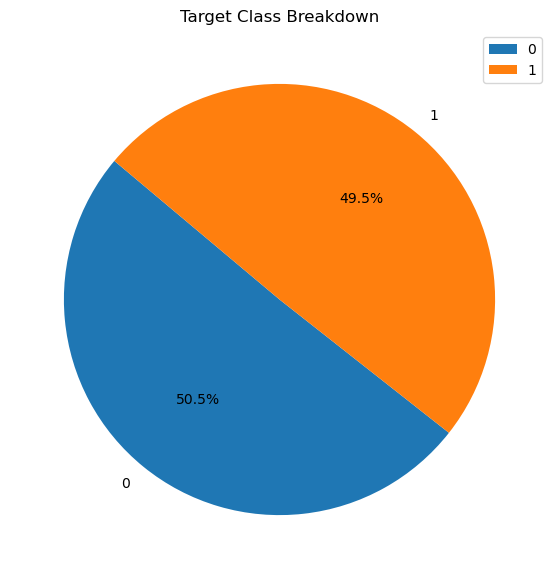

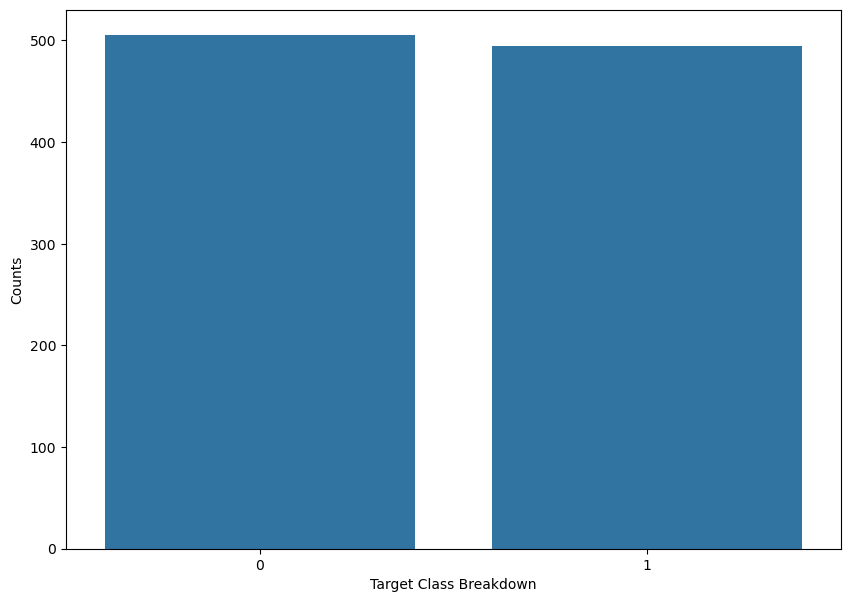

In [5]:
check_class_imbalance(df["Attrition"])

# We have a balanced dataset

In [6]:
df.dtypes

Employee_ID                int64
Age                        int64
Gender                    object
Department                object
Job_Title                 object
Years_at_Company           int64
Satisfaction_Level       float64
Average_Monthly_Hours      int64
Promotion_Last_5Years      int64
Salary                     int64
Attrition                  int64
dtype: object

In [7]:
df.describe()

,Employee_ID,Age,Years_at_Company,Satisfaction_Level,Average_Monthly_Hours,Promotion_Last_5Years,Salary,Attrition
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,42.205000,5.605000,0.505995,199.493000,0.486000,64624.980000,0.495000
std,288.819436,10.016452,2.822223,0.289797,29.631908,0.500054,20262.984333,0.500225
min,0.000000,25.000000,1.000000,0.001376,150.000000,0.000000,30099.000000,0.000000
25%,249.750000,33.000000,3.000000,0.258866,173.000000,0.000000,47613.500000,0.000000
50%,499.500000,43.000000,6.000000,0.505675,201.000000,0.000000,64525.000000,0.000000
75%,749.250000,51.000000,8.000000,0.761135,225.000000,1.000000,81921.000000,1.000000
max,999.000000,59.000000,10.000000,0.999979,249.000000,1.000000,99991.000000,1.000000


In [8]:
df.drop("Employee_ID", axis=1, inplace=True)

# Heatmap

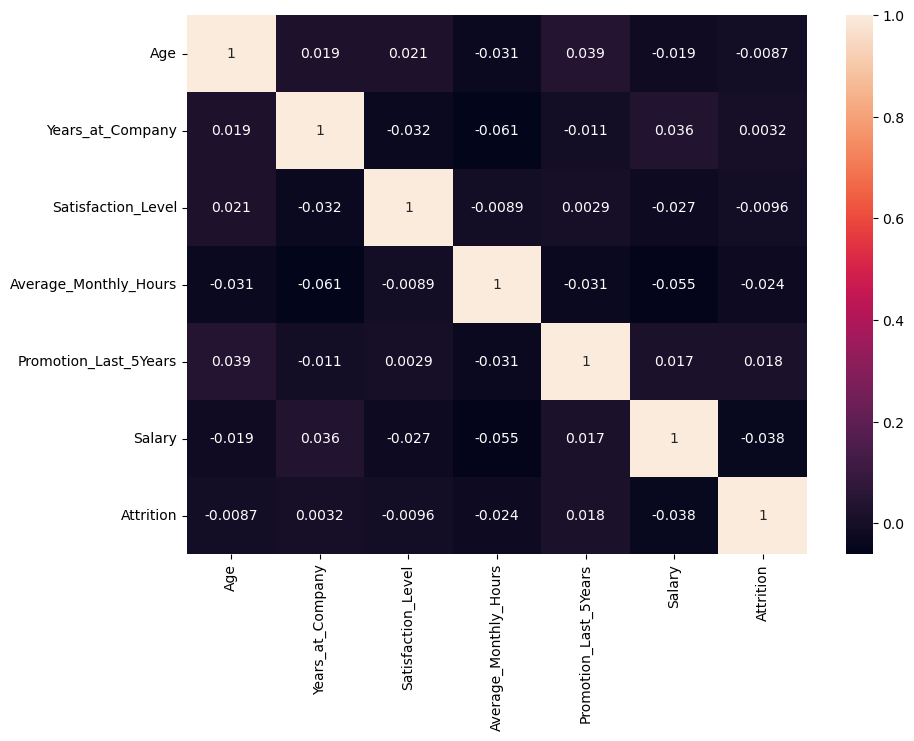

In [9]:
relations = df.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(data=relations, annot=True)
plt.show()

# Separate Numerical features and Categorical features

In [10]:
cat_features = df.select_dtypes(include="object")
numerical_features = df.select_dtypes(include=["int64", "float64"])

# Histogram

ValueError: num must be 1 <= num <= 4, not 5

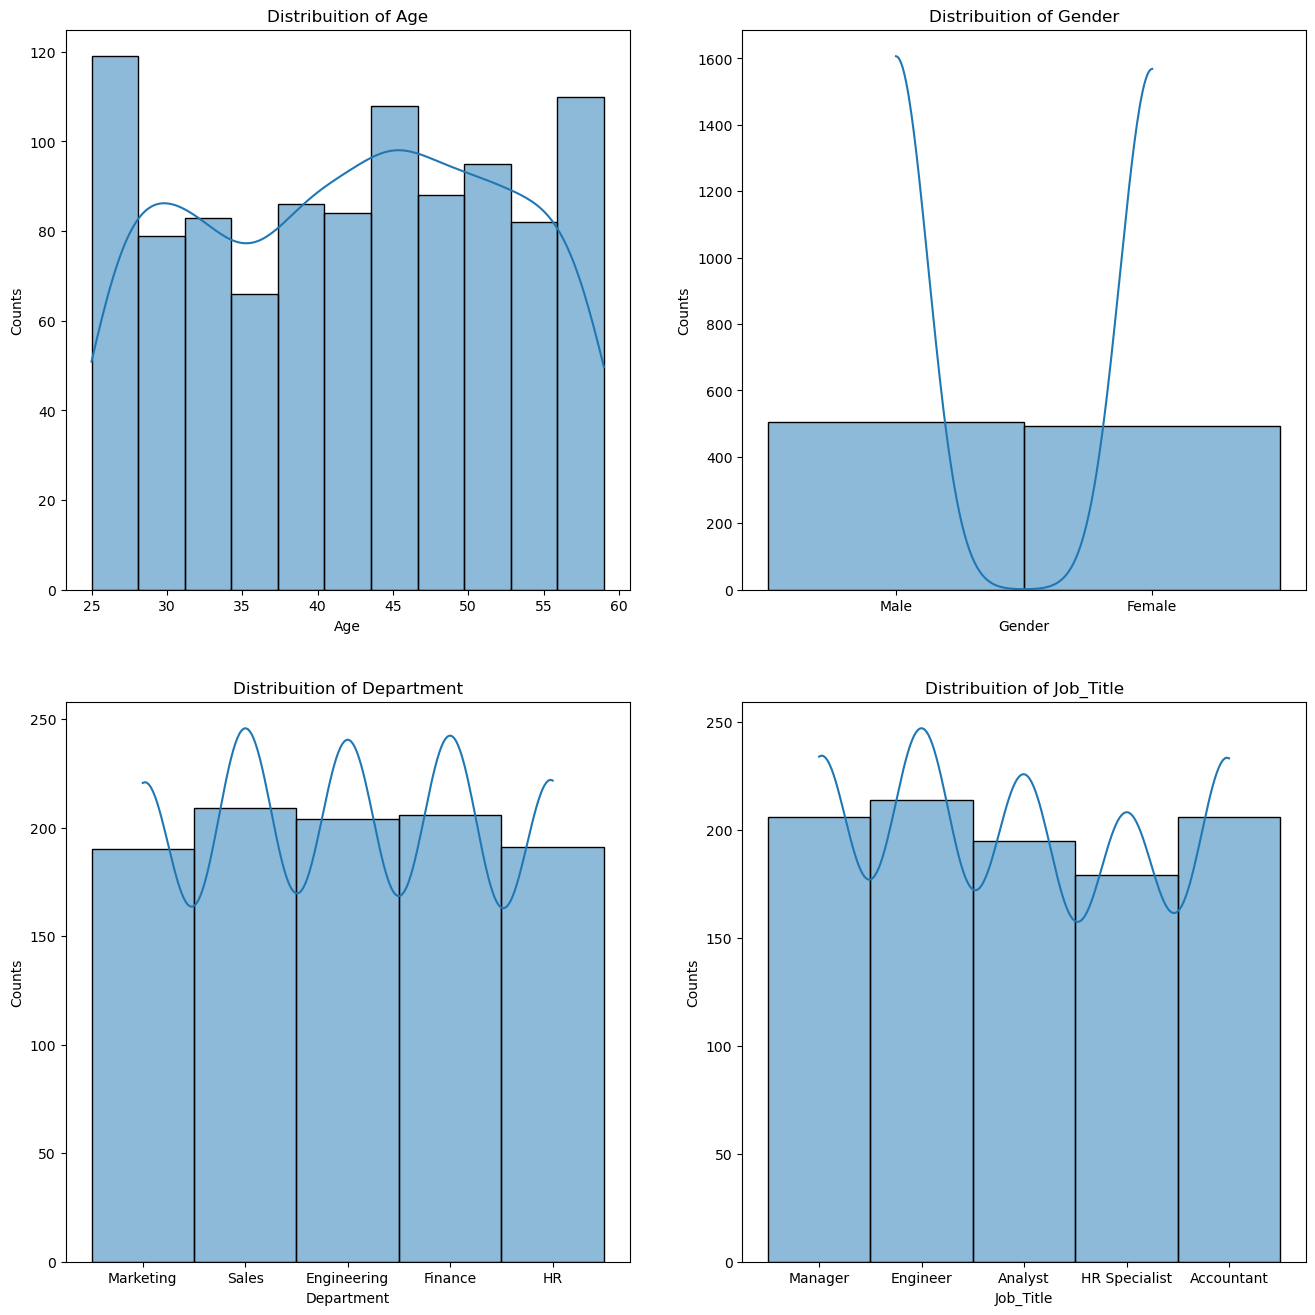

In [11]:
plot_distribution(df, "Hist")

# Boxplot

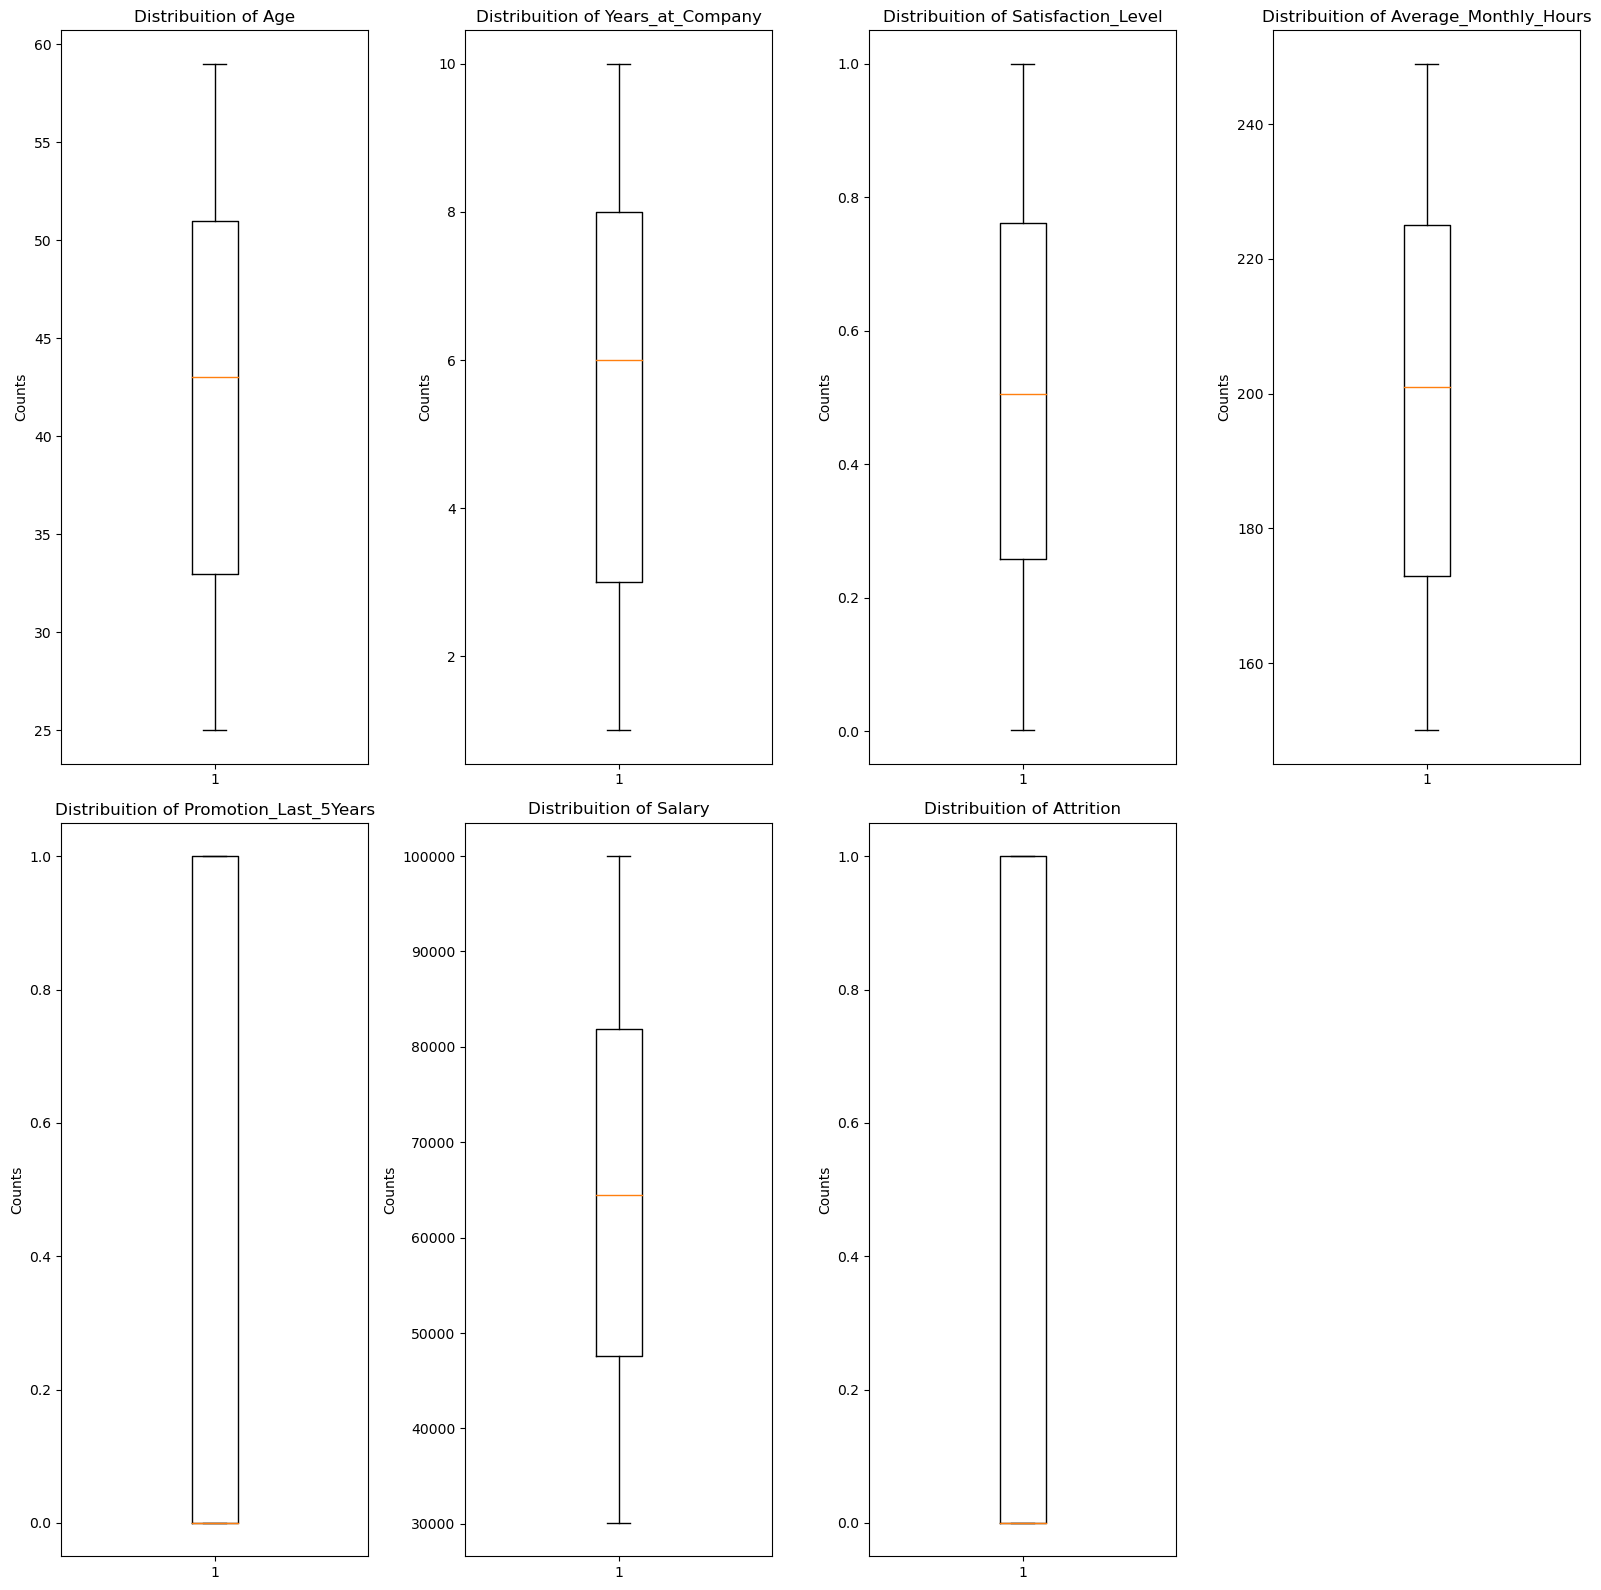

In [ ]:
plot_distribution(numerical_features, "Box")

# Aggregate Dataframe metrics

# Sum

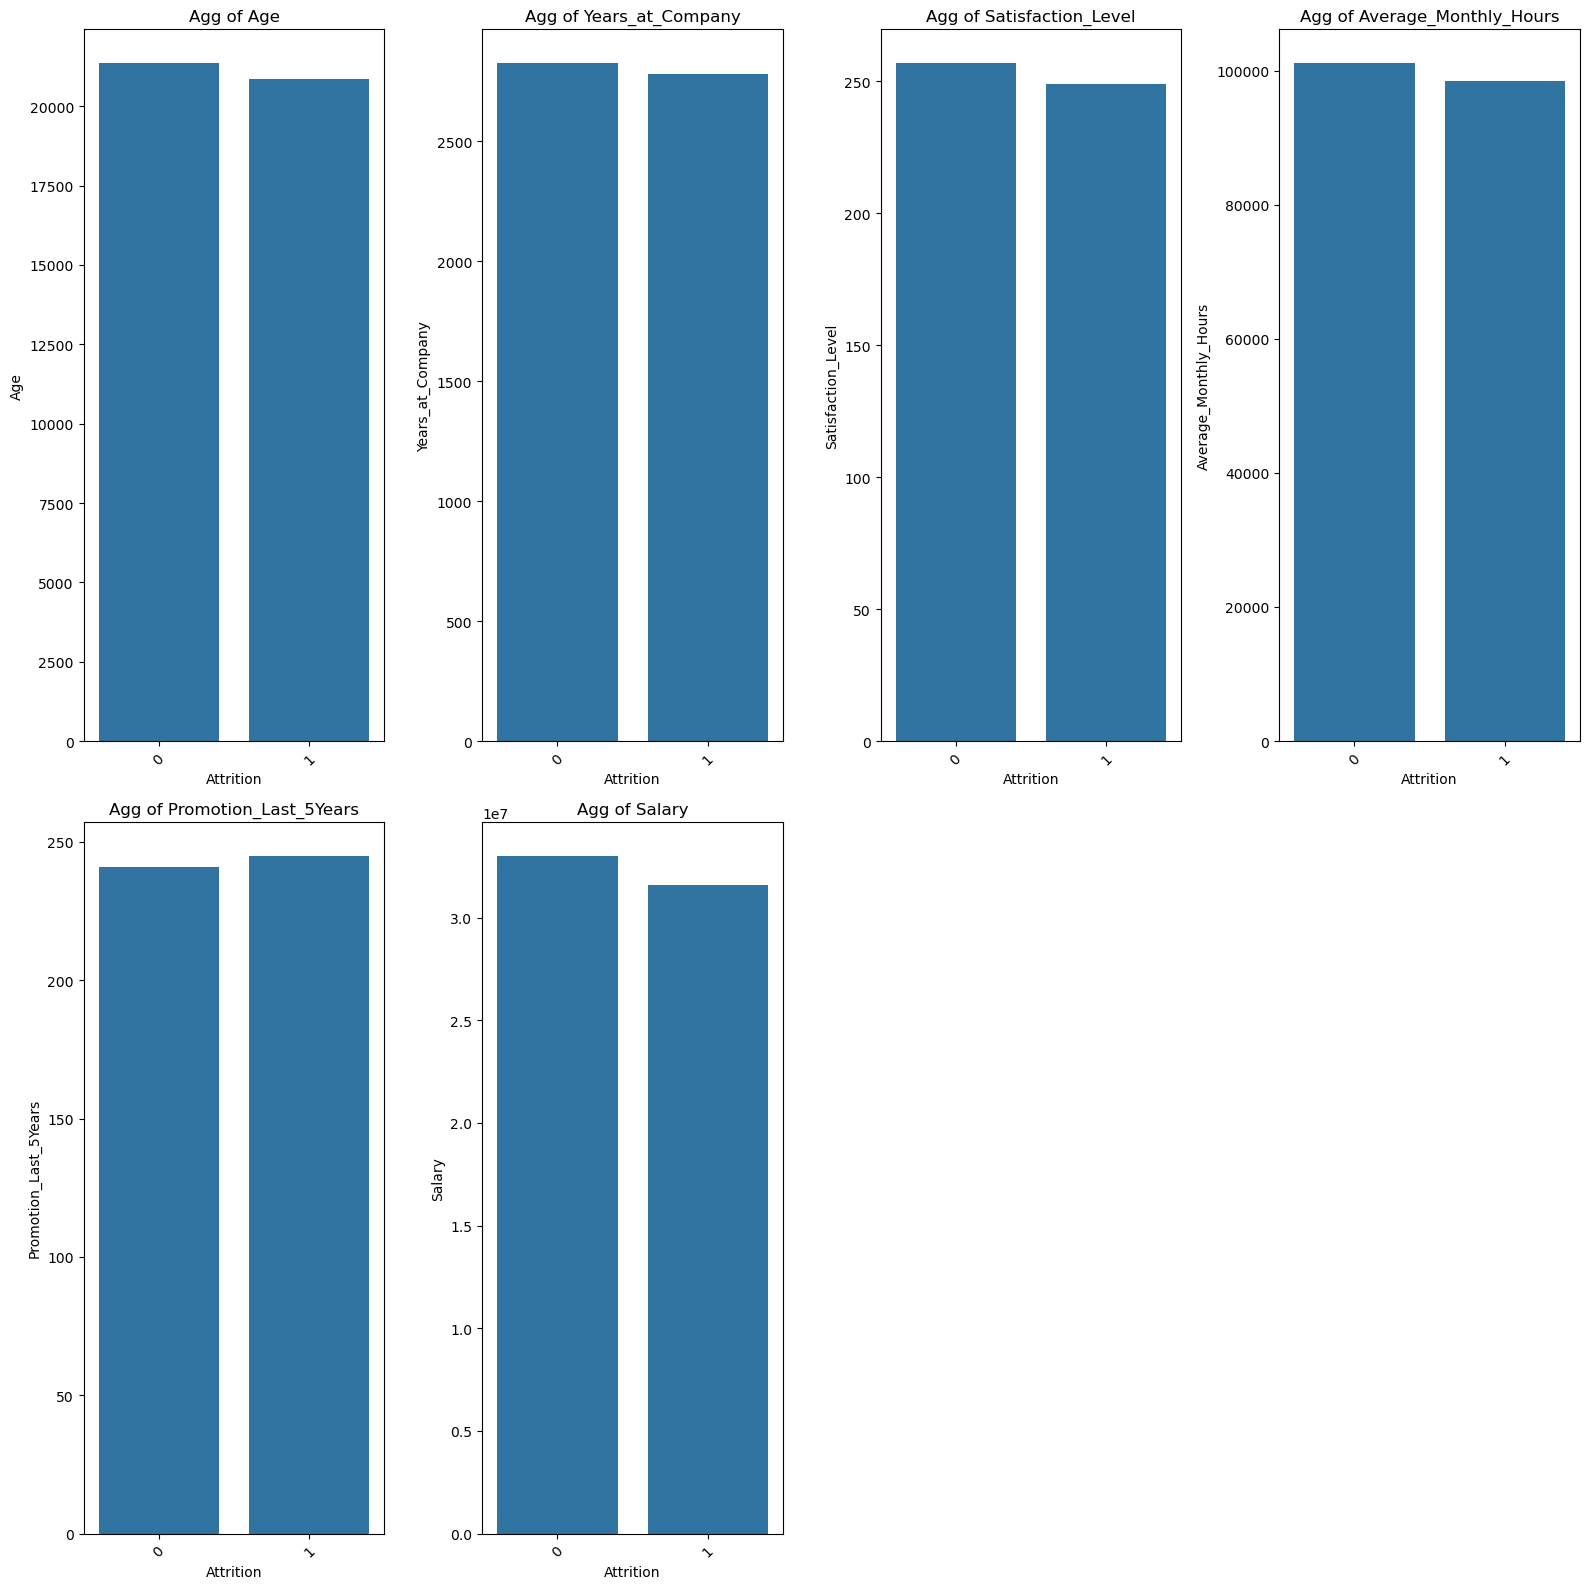

In [ ]:
aggregate_dataset(numerical_features, numerical_features.columns[:-1], "Attrition", "sum")

# Mean

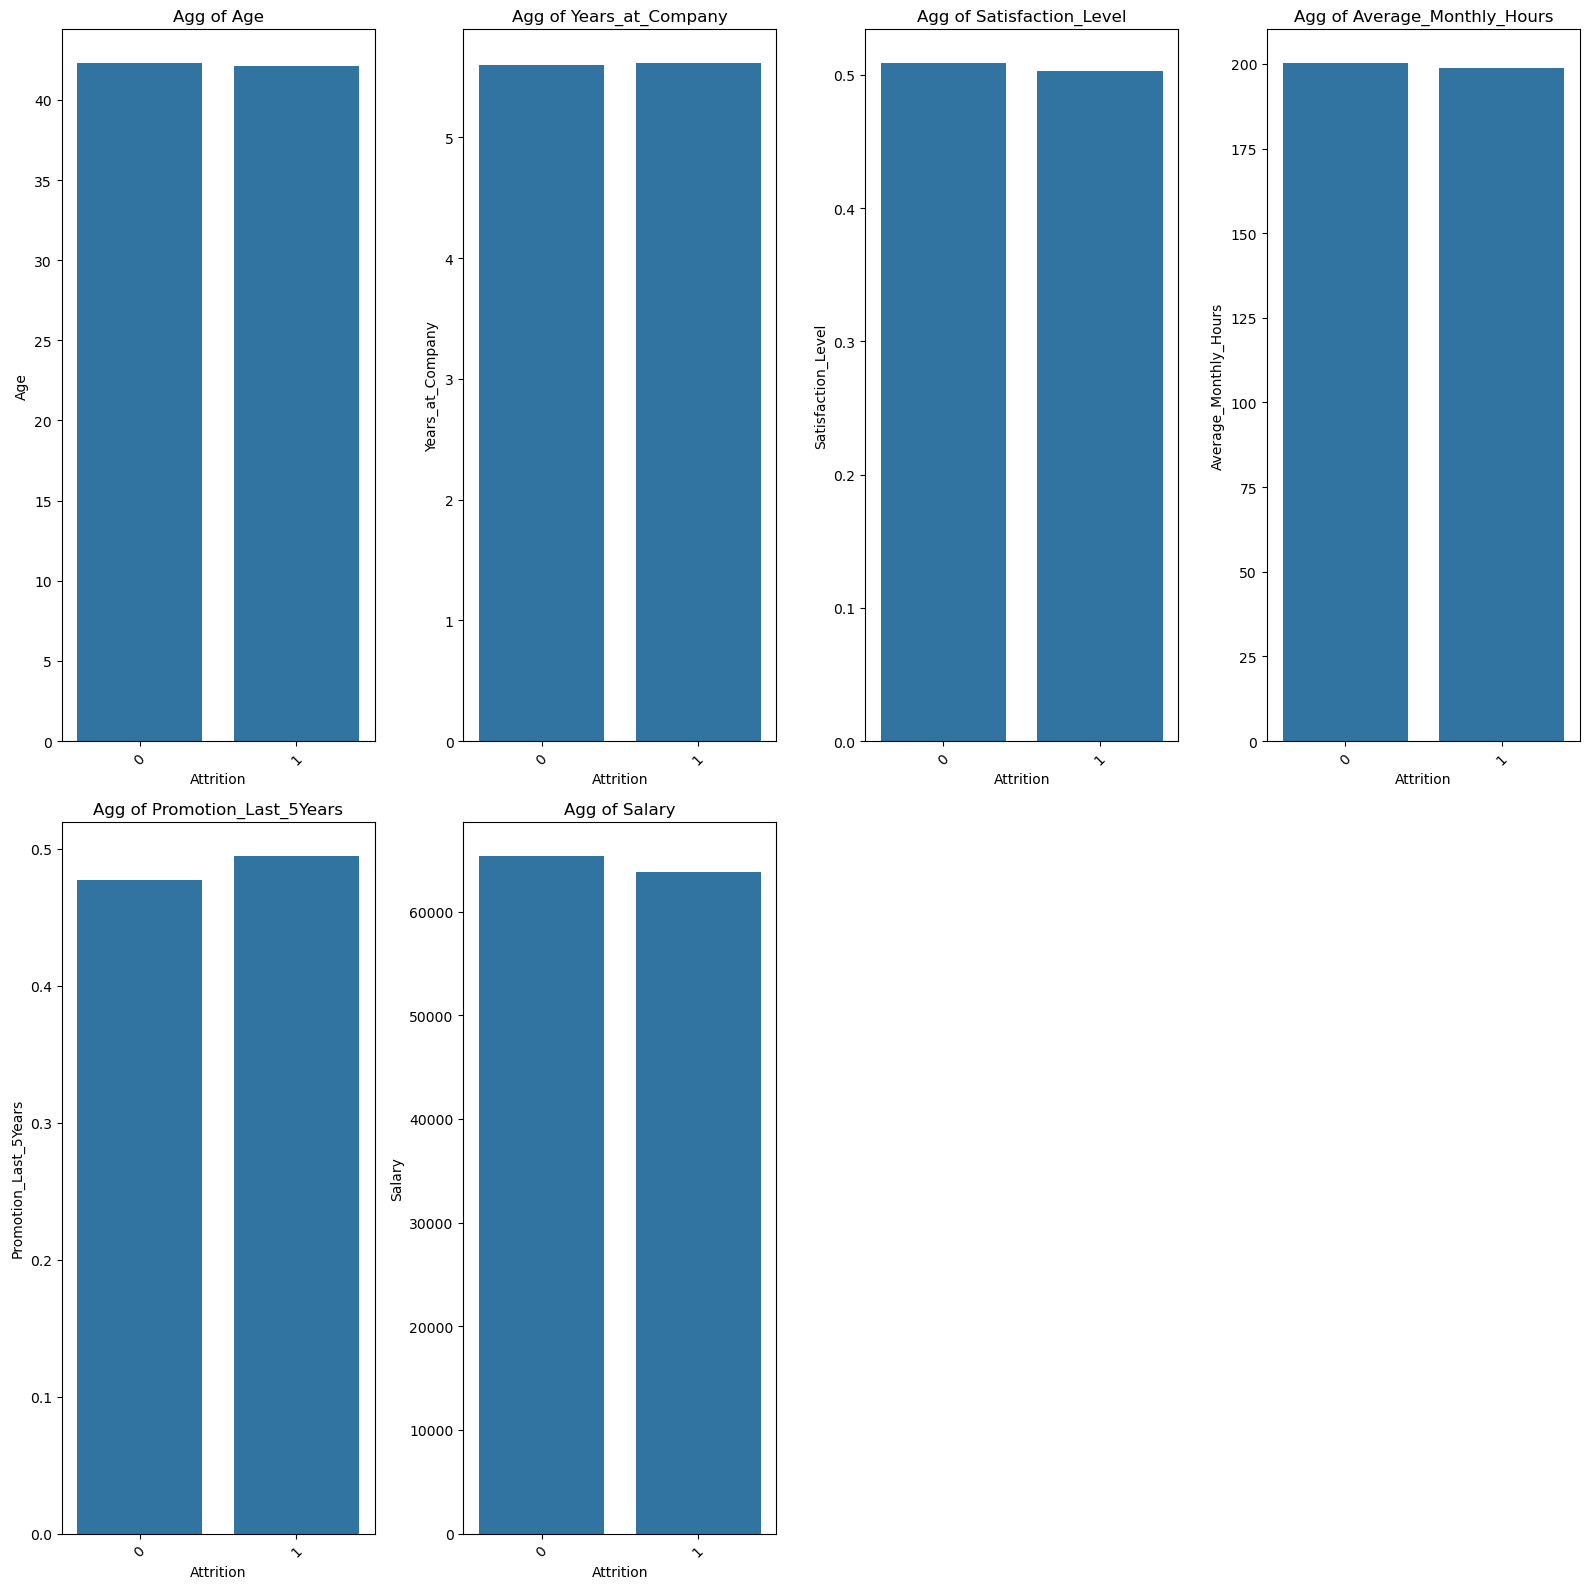

In [ ]:
aggregate_dataset(numerical_features, numerical_features.columns[:-1], "Attrition", "mean")

# Create Preprocessor

In [15]:
preproccessor = create_column_transformer(cat_features.columns, numerical_features.columns[:-1])
preproccessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['Gender', 'Department', 'Job_Title'], dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['Age', 'Years_at_Company', 'Satisfaction_Level',
       'Average_Monthly_Hours', 'Promotion_Last_5Years', 'Salary'],
      dtype='object'))])

# Separate Feature Variables

In [13]:
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

# Create Metrics

In [17]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="binary")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='binary')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='binary')

# Create Baseline Model

In [18]:
model_names = ["DUMMY"]
models = grab_selected_models(model_names)
test_selected_models(preproccessor, model_names, models, X, y, acc_metric)

   Model   Mean    Var    STD  Test-Acc  recall-Score  precision-Score  \
0  DUMMY  0.497  0.002  0.048     0.497         0.527            0.492   

   F1-Score  
0     0.509  


# PCA Analysis

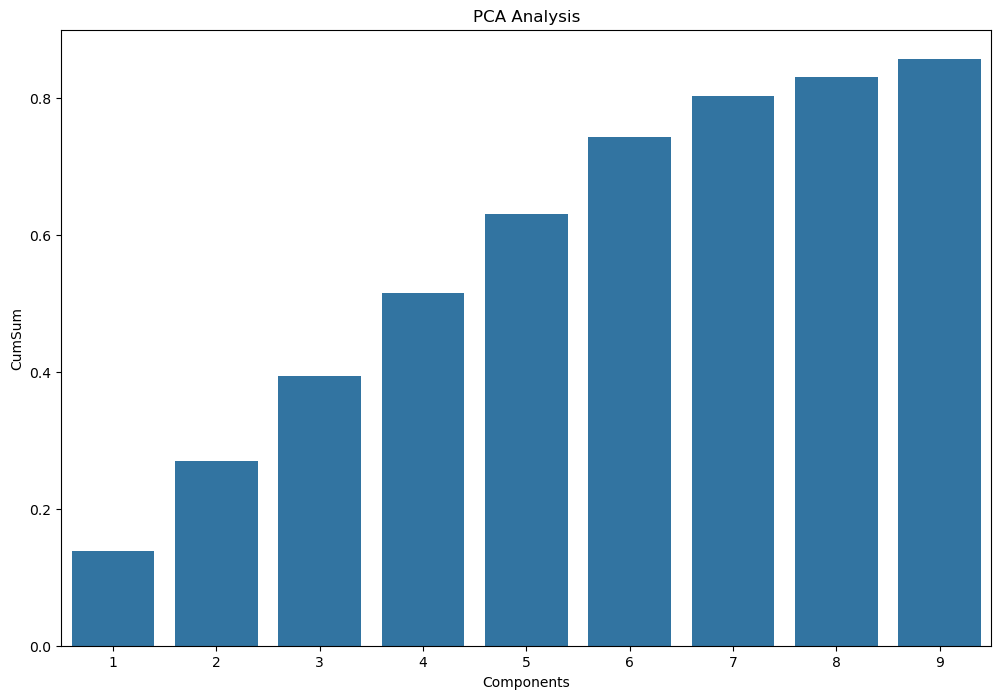

   Component    CumSum
0          1  0.138149
1          2  0.269745
2          3  0.393717
3          4  0.515367
4          5  0.630562
5          6  0.743695
6          7  0.803882
7          8  0.830678
8          9  0.857201


In [20]:
pca_analysis(X, preproccessor)

# Test Kbest Columns

# F-Classif

In [24]:
metric = f_classif
model_names = ["LR"]
models = grab_selected_models(model_names)[0]
test_kbest_columns(preproccessor, X, y, models, model_names[0], metric)

  Model  K  acc_metric  f1_metric    recall  precision
0    LR  1    0.484848   0.615385  0.834356   0.487455
1    LR  2    0.493939   0.559367  0.650307   0.490741
2    LR  3    0.484848   0.585366  0.736196   0.485830
3    LR  4    0.484848   0.585366  0.736196   0.485830
4    LR  5    0.487879   0.518519  0.558282   0.484043
5    LR  6    0.496970   0.528409  0.570552   0.492063
6    LR  7    0.487879   0.518519  0.558282   0.484043
7    LR  8    0.490909   0.525424  0.570552   0.486911
8    LR  9    0.484848   0.517045  0.558282   0.481481
